In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

mpl.rcParams['figure.figsize'] = [8.0*2, 6.0*2]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'



# Introduction

On fait des plots sur les runs

In [3]:
from problem.workflow import pprint

## Data

In [4]:
from problem.mnist import load_data

In [5]:
X, y = load_data()

## Load models

In [6]:
from problem.mnist import get_save_directory
from problem.mnist import preprocessing
from problem.mnist import skew
from problem.mnist import tangent
from problem.mnist import get_cv_iter


In [7]:
def load_models(model_class, *args, **kwargs):
    models = []
    cv_iter = get_cv_iter(X, y)
    n_cv = len(cv_iter)
    pprint('Loading', n_cv, model_class.__name__)
    for i in range(n_cv):
        model = model_class(*args, **kwargs)
        save_directory = get_save_directory()
        model_name = '{}-{}'.format(model.get_name(), i)
        path = os.path.join(save_directory, model_name)
        model.load(path)
        models.append(model)
    return models

In [8]:
from models.mnist import NeuralNetModel
from models.mnist import AugmentedNeuralNetModel
from models.mnist import TangentPropModel
from models.mnist import AugmentedTangentPropModel
from models.mnist import PivotModel


In [9]:
NN_models = load_models(NeuralNetModel, n_steps=10000, batch_size=128, cuda=True)
ANN_models = load_models(AugmentedNeuralNetModel, skewing_function=skew, n_augment=5,
                         batch_size=128, n_steps=10000, width=10., cuda=True)
TP_models = load_models(TangentPropModel, skewing_function=skew, trade_off=0.01, 
                        batch_size=128, n_steps=10000, cuda=True )
PAN_models = load_models(PivotModel, skewing_function=skew, batch_size=128, n_recovery_steps=5,
                         n_clf_pre_training_steps=3000, n_adv_pre_training_steps=3000, n_steps=10000,
                         width=10., trade_off=1.0, cuda=True)


2018-09-28 10:36:07 Loading 12 NeuralNetModel
2018-09-28 10:36:14 Loading 12 AugmentedNeuralNetModel
2018-09-28 10:36:14 Loading 12 TangentPropModel
2018-09-28 10:36:14 Loading 12 PivotModel


# Find adversarial perturbation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

from models.net.minibatch import OneEpoch
from models.net.utils import make_variable


In [11]:
def fast_gradient_sign_adversarial_noise(model, X_sample, y_sample, epsilon=0.1, batch_size=256):
    X_noise = []
    if hasattr(model, 'net'):
        net = model.net
    elif hasattr(model, 'jnet'):
        net = model.jnet
    elif hasattr(model, 'dnet'):
        net = model.dnet
    batch_gen = OneEpoch(X_sample, y_sample, batch_size=batch_size)
    for X_batch, y_batch in batch_gen:
        X_var = Variable(torch.FloatTensor(X_batch), requires_grad=True)
        X_var_cuda = X_var.cuda()
        y_var = Variable(torch.LongTensor(y_batch), requires_grad=False).cuda()
        net.zero_grad()
        outputs = net(X_var_cuda)
        loss = F.cross_entropy(outputs, y_var)
        loss.backward()
        X_perturb = epsilon * torch.sign(X_var.grad.data)
        X_noise.append(X_perturb.cpu().numpy())
    X_noise = np.concatenate(X_noise, axis=0)
    return X_noise


In [12]:
i = 0
cv_iter = get_cv_iter(X, y)
idx_dev, idx_valid = cv_iter[i]
X_test = X[idx_valid].reshape(-1, 28*28) / 255
y_test = y[idx_valid]
model = NN_models[i]
if hasattr(model, 'classifier'):
    model.clf = model.classifier

n_samples = X_test.shape[0]

X_noise = fast_gradient_sign_adversarial_noise(model, X_test, y_test)

y_pred = model.clf.predict(X_test)
y_pred_adv = model.clf.predict( np.clip(X_test+X_noise, 0, 1) )


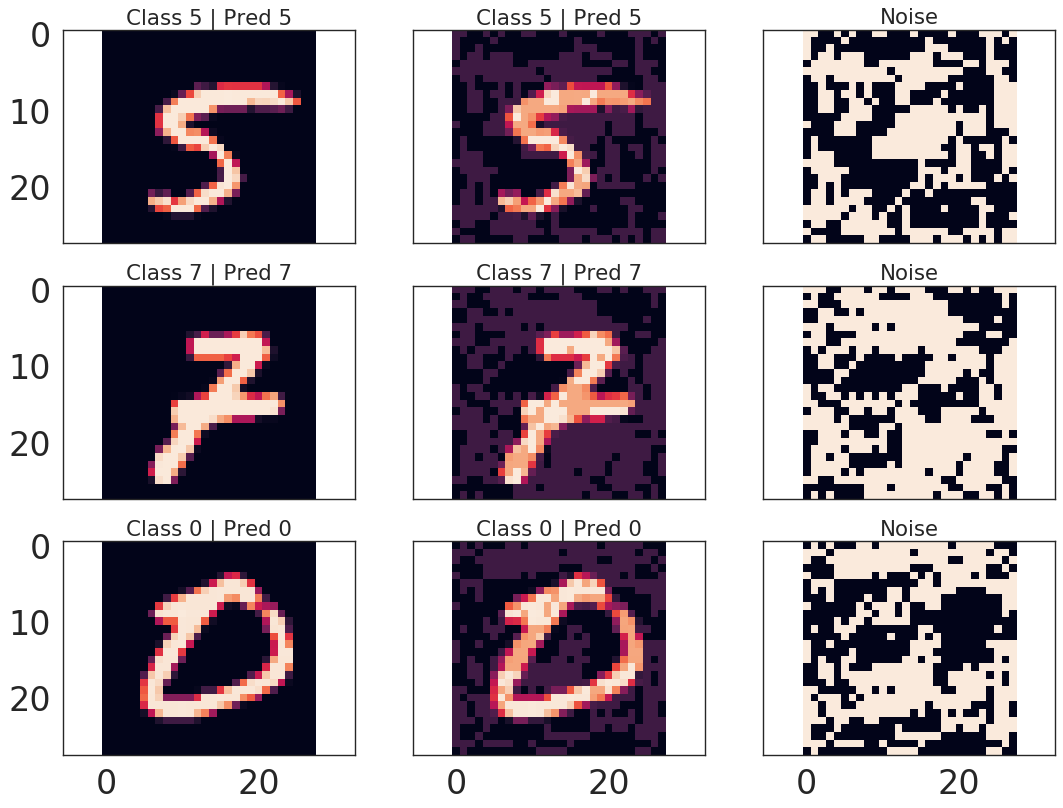

In [13]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
        
    idx = np.random.randint(0, n_samples)
    axes[0,0].imshow(X_test[idx].reshape(28, 28))
    axes[0,0].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred[idx]))
    axes[0,1].imshow((X_test[idx] + X_noise[idx]).reshape(28, 28))
    axes[0,1].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred_adv[idx]))
    axes[0,2].imshow(X_noise[idx].reshape(28, 28))
    axes[0,2].set_title('Noise')
    
    idx = np.random.randint(0, n_samples)
    axes[1,0].imshow(X_test[idx].reshape(28, 28))
    axes[1,0].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred[idx]))
    axes[1,1].imshow((X_test[idx] + X_noise[idx]).reshape(28, 28))
    axes[1,1].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred_adv[idx]))
    axes[1,2].imshow(X_noise[idx].reshape(28, 28))
    axes[1,2].set_title('Noise')
    
    idx = np.random.randint(0, n_samples)
    axes[2,0].imshow(X_test[idx].reshape(28, 28))
    axes[2,0].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred[idx]))
    axes[2,1].imshow((X_test[idx] + X_noise[idx]).reshape(28, 28))
    axes[2,1].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred_adv[idx]))
    axes[2,2].imshow(X_noise[idx].reshape(28, 28))
    axes[2,2].set_title('Noise')
    
    plt.show()
    

In [20]:
# print(j, '/', n_samples, j/n_samples*100, '%', 'zero loss')

In [21]:
# with sns.axes_style("white"):
#     plt.imshow(x_batch.reshape(28, 28))
#     plt.show()
#     plt.imshow(x_adversarial.reshape(28, 28))
#     plt.show()
#     plt.imshow(x_perturb.reshape(28, 28))
#     plt.show()

# Corelation ?

In [22]:
X_tan = tangent(X_test.reshape(-1, 28, 28, 1))
X_tan = X_tan.reshape(-1, 28*28)


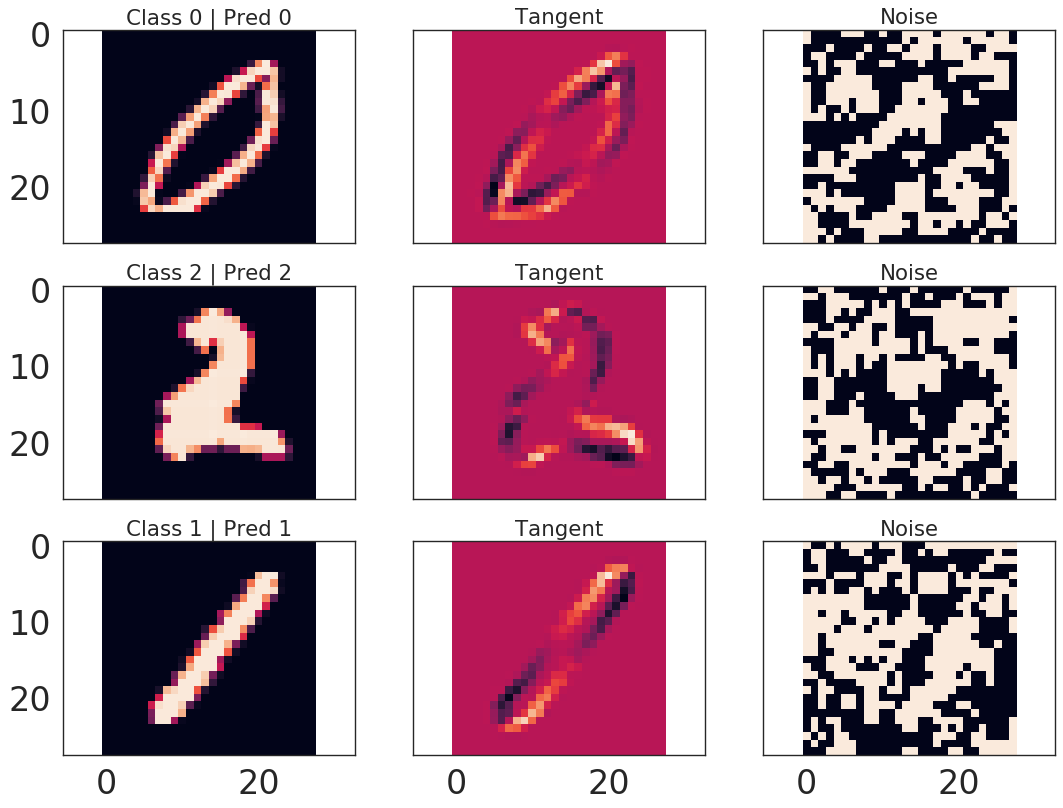

In [31]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
        
    idx = np.random.randint(0, n_samples)
    axes[0,0].imshow(X_test[idx].reshape(28, 28))
    axes[0,0].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred[idx]))
    axes[0,1].imshow(X_tan[idx].reshape(28, 28))
    axes[0,1].set_title('Tangent')
    axes[0,2].imshow(X_noise[idx].reshape(28, 28))
    axes[0,2].set_title('Noise')
    
    idx = np.random.randint(0, n_samples)
    axes[1,0].imshow(X_test[idx].reshape(28, 28))
    axes[1,0].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred[idx]))
    axes[1,1].imshow(X_tan[idx].reshape(28, 28))
    axes[1,1].set_title('Tangent')
    axes[1,2].imshow(X_noise[idx].reshape(28, 28))
    axes[1,2].set_title('Noise')
    
    idx = np.random.randint(0, n_samples)
    axes[2,0].imshow(X_test[idx].reshape(28, 28))
    axes[2,0].set_title('Class {} | Pred {}'.format(y_test[idx], y_pred[idx]))
    axes[2,1].imshow(X_tan[idx].reshape(28, 28))
    axes[2,1].set_title('Tangent')
    axes[2,2].imshow(X_noise[idx].reshape(28, 28))
    axes[2,2].set_title('Noise')
    
    plt.show()
    

# Measure distance between 2 distribs

- On the complete dataset
- On selected thresolds

# Playground

In [14]:
y_pred_adv = model.clf.predict( np.clip(X_test+X_noise, 0, 1) )
np.sum(y_pred_adv == y_test)

3262